In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [4]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [5]:
train_data_path = 'data/mnist_rot/mnist_all_rotation_normalized_float_train_valid.amat'
test_data_path = 'data/mnist_rot/mnist_all_rotation_normalized_float_test.amat'

In [14]:
train_data = []
train_labels = []

with open(train_data_path) as file:
    for line in file:
        line_split = line.split()
        train_data.append([float(x) for x in line_split[:-1]])
        train_labels.append(int(float(line_split[-1])))
        
train_data = np.reshape(np.array(train_data), (-1, 28, 28))
train_labels = np.array(train_labels)
train_data.shape, train_labels.shape

((12000, 28, 28), (12000,))

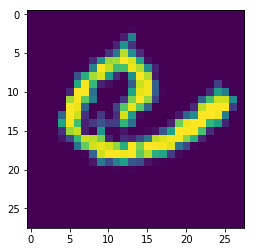

In [15]:
plt.imshow(train_data[0])

In [16]:
test_data = []
test_labels = []

with open(test_data_path) as file:
    for line in file:
        line_split = line.split()
        test_data.append([float(x) for x in line_split[:-1]])
        test_labels.append(int(float(line_split[-1])))
        
test_data = np.reshape(np.array(test_data), (-1, 28, 28))
test_labels = np.array(test_labels)
test_data.shape, test_labels.shape

((50000, 28, 28), (50000,))

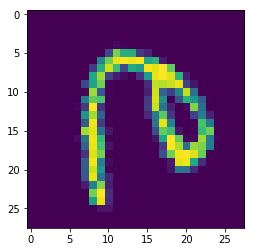

In [17]:
plt.imshow(test_data[0])

In [24]:
train_data = np.expand_dims(train_data, 1)
test_data = np.expand_dims(test_data, 1)

In [18]:
batch_size = 32

In [19]:
class ModelFullyConnected(nn.Module):
    def __init__(self, input_shape, output_size, num_hidden=1, hidden_dim=200, nonlinearity=nn.ReLU):
        super(type(self), self).__init__()
        self.nonlinearity = nonlinearity()
        input_size = int(np.prod(np.array(input_shape, dtype=int)))
        self.input_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, output_size)
        
    def forward(self, X):
        Z = self.input_layer(X.view(X.size(0), -1))
        for layer in self.hidden_layers:
            Z = layer(self.nonlinearity(Z))
        return F.log_softmax(self.output_layer(self.nonlinearity(Z)), dim=1)

In [44]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size, 
        num_blocks=1, num_filters=16, filter_size=3, num_dense_units=256, 
        nonlinearity=nn.ReLU
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        shape = input_shape[1]
        in_channels = input_shape[0]
        out_channels = num_filters // (2 ** (num_blocks-1))
        self.hidden_layers = nn.ModuleList()
        for i in range(num_blocks):
            self.hidden_layers.append(nn.Conv2d(in_channels, out_channels, filter_size))
            shape = shape - (filter_size - 1)
            self.hidden_layers.append(nonlinearity())
            in_channels, out_channels = out_channels, num_filters // (2 ** (num_blocks-i-1))
            self.hidden_layers.append(nn.Conv2d(in_channels, out_channels, filter_size))
            shape = shape - (filter_size - 1)
            self.hidden_layers.append(nn.MaxPool2d(2))
            shape = shape // 2
            self.hidden_layers.append(nonlinearity())
            in_channels, out_channels = out_channels, num_filters // (2 ** (num_blocks-i-2))

        #in_channels = num_filters * shape * shape
        #out_channels = num_dense_units
        self.output_layers = nn.ModuleList()
        self.output_layers.append(nn.Linear(num_filters * shape * shape, num_dense_units))
        self.output_layers.append(nonlinearity())
        self.output_layers.append(nn.Linear(num_dense_units, output_size))
        
    def forward(self, X):
        for layer in self.hidden_layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        for layer in self.output_layers:
            X = layer(X)
        return F.log_softmax(X, dim=1)

In [20]:
def symmetry_direction(X):
    # horizontal translation:
    #return torch.cat((X[:, :, :, 1:], X[:, :, :, :1]), dim=-1) - torch.cat((X[:, :, :, -1:], X[:, :, :, :-1]), dim=-1)
    
    # rotation:
    N, C, H, W = X.size()
    return -(Variable(cuda_wrapper(torch.arange(H))) - H // 2).view(1, 1, -1, 1) * \
            0.5 * (
                torch.cat((X[:, :, :, 1:], X[:, :, :, :1]), dim=-1) - \
                torch.cat((X[:, :, :, -1:], X[:, :, :, :-1]), dim=-1)
            ) + (Variable(cuda_wrapper(torch.arange(W))) - W // 2).view(1, 1, 1, -1) * \
            0.5 * (
                torch.cat((X[:, :, 1:], X[:, :, :1]), dim=-2) - \
                torch.cat((X[:, :, -1:], X[:, :, :-1]), dim=-2)
            )

In [22]:
def constrain_loss_function(model_output, model_input):
    # model_output: [batch_size x num_classes]
    # model_input: [batch_size x C x H x W]
    batch_size, num_classes = model_output.size()
    grad_output_wrt_input_for_each_class = []
    for output in torch.unbind(torch.sum(model_output, dim=0)):
        grad_output_wrt_input_for_each_class.append(
            autograd.grad([output], [model_input], create_graph=True)[0]
        ) # [batch_size x C x H x W]
    grad_output_wrt_input = torch.stack(grad_output_wrt_input_for_each_class) # [num_classes x batch_size x C x H x W]
    sym_dir = symmetry_direction(model_input) # [batch_size x C x H x W]
    return torch.sum((grad_output_wrt_input * sym_dir.view(1, *model_input.size())) ** 2) / batch_size

In [33]:
def batch_generator(data, labels, batch_size):
    assert data.shape[0] == labels.shape[0]
    data_size = data.shape[0]
    indices = np.random.permutation(data_size)
    for i in range(0, data_size, batch_size):
        if i+batch_size > data_size:
            yield torch.from_numpy(data[indices[i:]]).float(), torch.from_numpy(labels[indices[i:]])
        else:
            yield (
                torch.from_numpy(data[indices[i:i+batch_size]]).float(), 
                torch.from_numpy(labels[indices[i:i+batch_size]])
            )

In [23]:
def random_input_generator(input_shape, batch_size):
    while True:
        # generate uniform noise:
        yield torch.rand(batch_size, *input_shape)

In [32]:
train_data.shape

(12000, 1, 28, 28)

In [75]:
from time import time

num_epochs = 40

input_shape = (1, 28, 28)
output_size = 10

eta_start = 0.0001
eta_end = eta_start
eta_growth_factor = ((eta_end + 1e-8) / (eta_start + 1e-8)) ** (1 / num_epochs)

torch.manual_seed(123)
np.random.seed(123)
#model = cuda_wrapper(ModelFullyConnected(input_shape, output_size, num_hidden=2, hidden_dim=3*32*32))
#model = cuda_wrapper(
#    ModelConvolutional(
#        input_shape, output_size, num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512, nonlinearity=nn.ReLU
#    )
#)
#optimizer = optim.Adam(model.parameters())
loss_function = nn.NLLLoss()

random_input_gen = random_input_generator(input_shape, batch_size)

for epoch in range(num_epochs):
    start_time = time()
    
    eta = eta_start * eta_growth_factor ** epoch
            
    cum_loss_data = 0
    cum_loss_constrain = 0
    cum_loss_full = 0
    cum_acc = 0
    batch_count = 0

    train_loader = batch_generator(train_data, train_labels, batch_size)
    for X, y in train_loader:
        X, y = cuda_wrapper(Variable(X, requires_grad=True)), cuda_wrapper(Variable(y))
        prediction = model(X)
        
        loss_data = loss_function(prediction, y)
        cum_loss_data += loss_data.data[0]
        
        #X_random = cuda_wrapper(Variable(next(random_input_gen), requires_grad=True))
        #loss_constrain = constrain_loss_function(model(X_random), X_random)
        
        loss_constrain = constrain_loss_function(prediction, X)
        cum_loss_constrain += loss_constrain.data[0]
        
        loss_full = loss_data + eta * loss_constrain
        #loss_full = loss_data
        cum_loss_full += loss_full.data[0]
            
        acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
        cum_acc += acc.data[0]
        
        optimizer.zero_grad()
        loss_full.backward()
        optimizer.step()
        batch_count += 1
            
    mean_train_loss_data = cum_loss_data / batch_count
    mean_train_loss_constrain = cum_loss_constrain / batch_count
    mean_train_loss_full = cum_loss_full / batch_count
    mean_train_acc = cum_acc / batch_count

    cum_loss_data = 0
    cum_loss_constrain = 0
    cum_acc = 0
    batch_count = 0

    test_loader = batch_generator(test_data, test_labels, batch_size)
    for X, y in test_loader:
        X, y = cuda_wrapper(Variable(X, requires_grad=True)), cuda_wrapper(Variable(y))
        prediction = model(X)
        loss_data = loss_function(prediction, y)
        cum_loss_data += loss_data.data[0]
        
        loss_constrain = constrain_loss_function(prediction, X)
        cum_loss_constrain += loss_constrain.data[0]
        
        acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
        cum_acc += acc.data[0]

        batch_count += 1
            
    mean_test_loss_data = cum_loss_data / batch_count
    mean_test_loss_constrain = cum_loss_constrain / batch_count
    mean_test_acc = cum_acc / batch_count

    print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
    print('train loss:')
    print(
        'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
            mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
        )
    )
    print('train acc: {:.2f}'.format(mean_train_acc))
    print('test loss:')
    print(
        'data term: {:.2f}, constrain term: {:.2f}'.format(
            mean_test_loss_data, mean_test_loss_constrain
        )
    )
    print('test acc: {:.2f}'.format(mean_test_acc))
    print('eta = {:.3f}'.format(eta))
    print()


Epoch 1 of 40 took 52.99s;
train loss:
data term: 0.02, constrain term: 286.93, full: 0.05
train acc: 1.00
test loss:
data term: 0.19, constrain term: 270.62
test acc: 0.94
eta = 0.000

Epoch 2 of 40 took 53.22s;
train loss:
data term: 0.02, constrain term: 279.24, full: 0.05
train acc: 1.00
test loss:
data term: 0.28, constrain term: 332.57
test acc: 0.92
eta = 0.000

Epoch 3 of 40 took 53.16s;
train loss:
data term: 0.02, constrain term: 290.58, full: 0.05
train acc: 1.00
test loss:
data term: 0.18, constrain term: 293.31
test acc: 0.94
eta = 0.000

Epoch 4 of 40 took 53.27s;
train loss:
data term: 0.02, constrain term: 269.73, full: 0.04
train acc: 1.00
test loss:
data term: 0.20, constrain term: 305.03
test acc: 0.94
eta = 0.000

Epoch 5 of 40 took 53.30s;
train loss:
data term: 0.02, constrain term: 277.60, full: 0.05
train acc: 1.00
test loss:
data term: 0.22, constrain term: 313.52
test acc: 0.93
eta = 0.000

Epoch 6 of 40 took 52.97s;
train loss:
data term: 0.02, constrain term

In [ ]:
# MNIST-rot. batch_size=32
# Constrain term uses log probability
# (<data term>, <constrain term>, <train acc>), (<best test loss>, <constrain term>, <best test acc>))

# ModelConvolutional(num_blocks=2, num_filters=32, filter_size=3, num_dense_units=512)
# Every 10 epochs:
# eta=0: {(0.04, 2756.66, 0.99), (0.27, 2650.09, 0.93)}
# eta=0.0001: {(0.06, 377.05, 0.98), (0.21, 378.77, 0.93)}, {(0.03, 328.89, 1.00), (0.20, 328.08, 0.94)}, 
#             {(0.03, 298.84, 1.00), (0.19, 289.73, 0.94)}, {(0.02, 284.55, 1.00), (0.17, 270.56, 0.95)}
# eta=0.001: {(0.18, 93.10, 0.96), (0.25, 94.70, 0.93)}, {(0.12, 94.18, 0.98), (0.22, 90.56, 0.94)}, 
#            {(0.10, 91.95, 0.99), (0.21, 96.31, 0.94)}, {(0.09, 90.46, 0.99), (0.21, 91.67, 0.94)}
# eta=0.01: {(0.48, 20.14, 0.90), (0.48, 20.51, 0.89)}, {(0.42, 20.60, 0.92), (0.44, 20.14, 0.91)}, 
#           {(0.39, 20.57, 0.93), (0.42, 21.28, 0.91)}


In [ ]:
mean_distances_rot = {}
mean_distances_trans = {}

In [71]:
from scipy.ndimage import rotate

mean_distances_rot[eta_start] = []
rot_angle_step = 15
num_symmetries = 360 // rot_angle_step

for k in range(num_symmetries):
    distances = []
    test_loader = batch_generator(test_data, test_labels, batch_size)
    for X, y in test_loader:
        X_transformed = torch.from_numpy(
            rotate(X.numpy(), k * rot_angle_step, axes=(3, 2), reshape=False, mode='constant', order=3, prefilter=True)
        )
        log_distr = model(cuda_wrapper(Variable(X))).data
        log_distr_transformed = model(cuda_wrapper(Variable(X_transformed))).data
        distance = 0.5 * torch.sum(
            (torch.exp(log_distr) - torch.exp(log_distr_transformed)) * (log_distr - log_distr_transformed)
        ) / batch_size
        distances.append(distance)
    
    mean_distances_rot[eta_start].append(np.mean(np.array(distances)))

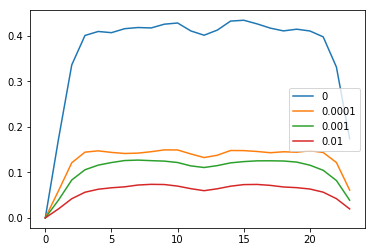

In [72]:
etas = [0, 0.0001, 0.001, 0.01]

for eta in etas:
    plt.plot(range(num_symmetries), mean_distances_rot[eta])
plt.legend(etas)

In [73]:
mean_distances_trans[eta_start] = []

num_symmetries_trans = 28
for k in range(1, num_symmetries_trans):
    distances = []
    test_loader = batch_generator(test_data, test_labels, batch_size)
    for X, y in test_loader:
        X = cuda_wrapper(Variable(X))
        X_transformed = torch.cat((X[:, :, :, k:], X[:, :, :, :k]), dim=-1)
        log_distr = model(X).data
        log_distr_transformed = model(X_transformed).data
        distance = 0.5 * torch.sum(
            (torch.exp(log_distr) - torch.exp(log_distr_transformed)) * (log_distr - log_distr_transformed)
        ) / batch_size
        distances.append(distance)
    mean_distances_trans[eta_start].append(np.mean(np.array(distances)))

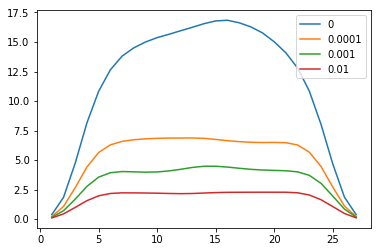

In [74]:
for eta in etas:
    plt.plot(range(1, num_symmetries_trans), mean_distances_trans[eta])
plt.legend(etas)